# File and libraries

In [1]:
import pandas as pd
import numpy as np


filepath=r'dataset/df_ecom_2_6_bal_input'
test_filepath= f"{filepath}_test.csv"
train_filepath= f"{filepath}_train.csv"

sample_filepath=f"{filepath}_sample.csv"
test_sample_filepath=f"{filepath}_test_sample.csv"
train_sample_filepath=f"{filepath}_train_sample.csv"

file_tag = "Multicategory Store"

# DSLabs functions

In [2]:
%run "dslabs_functions.py"


dslabs_functions lodaded


# Data functions

In [3]:
%run "data_functions.py"


dslabs_functions lodaded
data_functions loaded


# Load

In [4]:

# test_data=True
test_data=False

# use to evaluate strategies. otherwise False to just transform data 
evaluate=True
# evaluate=False


if test_data==True:

    df=pd.read_csv(f"{filepath}.csv")
    
    test= pd.read_csv(test_filepath)
    train= pd.read_csv(train_filepath)

    # sample
    sample=0.1
    df = df.groupby('day').apply(lambda x: sample_per_day(x, sample)).reset_index(drop=True)
    test = test.groupby('day').apply(lambda x: sample_per_day(x, sample)).reset_index(drop=True)
    train = train.groupby('day').apply(lambda x: sample_per_day(x, sample)).reset_index(drop=True)


    
    
else:
    # data=pd.read_csv(f"{filepath}.csv")  
    # test= pd.read_csv(test_filepath)
    # train= pd.read_csv(train_filepath)

    # use sample file when heavy processing
    df=pd.read_csv(sample_filepath)
    test= pd.read_csv(test_sample_filepath)
    train= pd.read_csv(train_sample_filepath)

 
target='is_purchase'
eval_metric_1 = 'precision'
eval_metric_2 = 'f2'
vars: list[str] = df.columns.to_list()
labels: list = list(df[target].unique())


# ensure sorting by day_of_year for correct splitting 
# "When in the presence of temporal data, data partition shall use older data to train and newer to test, in order to not use future data to classify past data. In any other case, partition shall be random."
df.sort_values(by='day', inplace=True)
test.sort_values(by='day', inplace=True)
train.sort_values(by='day', inplace=True)



df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21185 entries, 0 to 21184
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   category_code_lvl_1  21185 non-null  float64
 1   category_code_lvl_2  21185 non-null  float64
 2   price                21185 non-null  float64
 3   is_purchase          21185 non-null  int64  
 4   activity_in_session  21185 non-null  float64
 5   week_of_month        21185 non-null  int64  
 6   day                  21185 non-null  int64  
 7   brand_value          21185 non-null  float64
 8   product_category     21185 non-null  int64  
 9   day_of_week_sin      21185 non-null  float64
 10  day_of_week_cos      21185 non-null  float64
 11  hour_sin             21185 non-null  float64
 12  hour_cos             21185 non-null  float64
dtypes: float64(9), int64(4)
memory usage: 2.3 MB


# Distribution Check

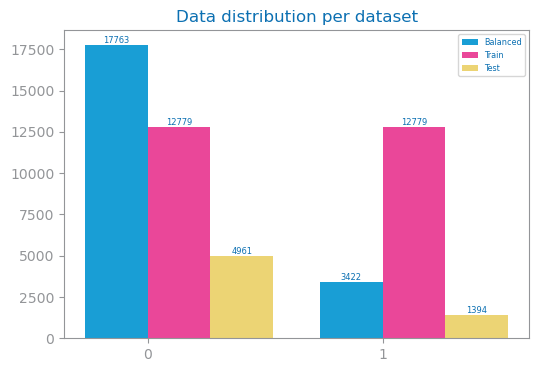

In [5]:
from pandas import concat
from matplotlib.pyplot import figure, show
from dslabs_functions import plot_multibar_chart


# Distribution check


# Create a dictionary to store original class counts
values: dict[str, list[int]] = {
    "Balanced": [
        len(df[df[target] == 0]),  # Assuming 0 is the negative class
        len(df[df[target] == 1]),  # Assuming 1 is the positive class
    ]
}

values["Train"] = [
    len(train[train[target] == 0]),
    len(train[train[target] == 1]),
]
values["Test"] = [
    len(test[test[target] == 0]),
    len(test[test[target] == 1]),
]

# Visualize the distribution
figure(figsize=(6, 4))
plot_multibar_chart(labels, values, title="Data distribution per dataset")
show()

# evaluate prep

In [6]:
trnX, tstX, trnY, tstY, labels, vars = read_train_test_from_files(train, test, target)
print(f'Train#={len(trnX)} Test#={len(tstX)}')
print(f'Labels={labels}')

Train#=25558 Test#=6355
Labels=[0, 1]


In [7]:

from numpy import array, ndarray
from matplotlib.pyplot import figure, subplots, savefig, show, suptitle  # Importando diretamente suptitle
from sklearn.ensemble import GradientBoostingClassifier
from dslabs_functions import (
    CLASS_EVAL_METRICS,
    DELTA_IMPROVE,
    read_train_test_from_files,
)
from dslabs_functions import HEIGHT, plot_evaluation_results, plot_multiline_chart


def gradient_boosting_study(
    trnX: ndarray,
    trnY: array,
    tstX: ndarray,
    tstY: array,
    nr_max_trees: int = 2500,
    lag: int = 500,
    metric: str = "accuracy",
    file_tag=''
) -> tuple[GradientBoostingClassifier | None, dict]:
    n_estimators: list[int] = [100] + [i for i in range(500, nr_max_trees + 1, lag)]
    max_depths: list[int] = [2, 5, 7]
    learning_rates: list[float] = [0.1, 0.3, 0.5, 0.7, 0.9]

    best_model: GradientBoostingClassifier | None = None
    best_params: dict = {"name": "GB", "metric": metric, "params": ()}
    best_performance: float = 0.0

    values: dict = {}
    cols: int = len(max_depths)
    _, axs = subplots(1, cols, figsize=(cols * HEIGHT, HEIGHT), squeeze=False)
    
    suptitle(f"{file_tag} Gradient Boosting study for {metric}")
    
    for i in range(len(max_depths)):
        d: int = max_depths[i]
        values = {}
        for lr in learning_rates:
            y_tst_values: list[float] = []
            for n in n_estimators:
                clf = GradientBoostingClassifier(
                    n_estimators=n, max_depth=d, learning_rate=lr
                )
                clf.fit(trnX, trnY)
                prdY: array = clf.predict(tstX)
                eval: float = CLASS_EVAL_METRICS[metric](tstY, prdY)
                y_tst_values.append(eval)
                if eval - best_performance > DELTA_IMPROVE:
                    best_performance = eval
                    best_params["params"] = (d, lr, n)
                    best_model = clf
                # print(f'GB d={d} lr={lr} n={n}')
            values[lr] = y_tst_values
        plot_multiline_chart(
            n_estimators,
            values,
            ax=axs[0, i],
            title=f"GB max_depth={d}",
            xlabel="nr estimators",
            ylabel=metric,
            percentage=True,
        )
    print(
        f'GB best for {best_params["params"][2]} trees (d={best_params["params"][0]} and lr={best_params["params"][1]}'
    )

    return best_model, best_params

# F2 Evaluate for best model

In [8]:
max_trees_eval= 700
max_trees_eval_lag=100

GB best for 100 trees (d=5 and lr=0.9


<Figure size 640x480 with 0 Axes>

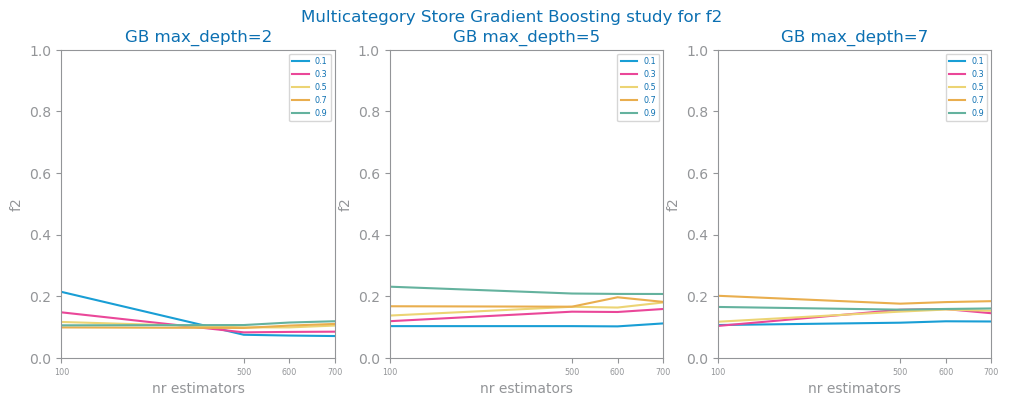

In [9]:
figure()


best_model_f2, f2_params = gradient_boosting_study(
trnX,
trnY,
tstX,
tstY,
nr_max_trees=max_trees_eval,
lag=max_trees_eval_lag,
metric='f2',
file_tag=file_tag
)

savefig(f'images/{file_tag}_GB_{f2_params['metric']}_study.png')
show()
    

## f2 study

In [10]:
##max_trees_eval=3000
##max_trees_eval_lag=300

In [11]:
##figure()
##
##
##best_model_f2, f2_params = gradient_boosting_study(
##trnX,
##trnY,
##tstX,
##tstY,
##nr_max_trees=max_trees_eval,
##lag=max_trees_eval_lag,
##metric='f2',
##file_tag=file_tag
##)
##
##savefig(f'images/{file_tag}_GB_{f2_params['metric']}_study.png')
##show()
    

## f2 Best Model Performance

max_trees_eval=700
max_trees_eval_lag=100

<Figure size 640x480 with 0 Axes>

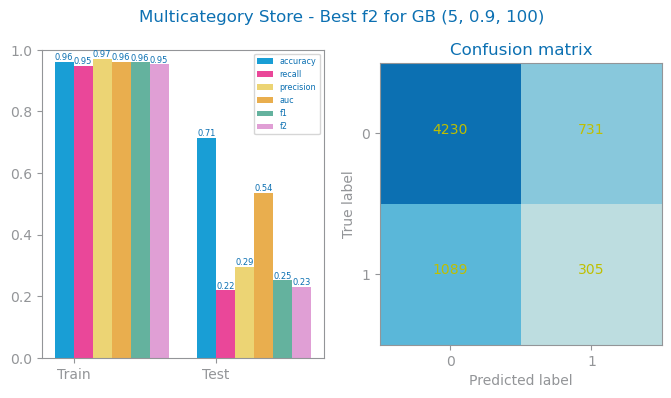

In [12]:
prd_trn: array = best_model_f2.predict(trnX)
prd_tst: array = best_model_f2.predict(tstX)
figure()
plot_evaluation_results(f2_params, trnY, prd_trn, tstY, prd_tst, labels, file_tag=file_tag)
savefig(f'images/{file_tag}_GB_{f2_params["name"]}_best_{f2_params["metric"]}_eval.png')
show()

max_trees_eval=3000
max_trees_eval_lag=300

In [13]:
##prd_trn: array = best_model_f2.predict(trnX)
##prd_tst: array = best_model_f2.predict(tstX)
##figure()
##plot_evaluation_results(f2_params, trnY, prd_trn, tstY, prd_tst, labels, file_tag=file_tag)
##savefig(f'images/{file_tag}_GB_{f2_params["name"]}_best_{f2_params["metric"]}_eval.png')
##show()

## f2 Variables importance


1. hour_cos (0.2322568793955808)
2. activity_in_session (0.20811224280119267)
3. day_of_week_sin (0.16117585538757728)
4. hour_sin (0.11352829315141737)
5. day (0.08502286580910588)
6. day_of_week_cos (0.0813694055560481)
7. product_category (0.05339759538668198)
8. price (0.03553203017750099)
9. week_of_month (0.016946332364315714)
10. brand_value (0.011851772224664138)
11. category_code_lvl_2 (0.0005940387357398357)
12. category_code_lvl_1 (0.00021268901017520124)


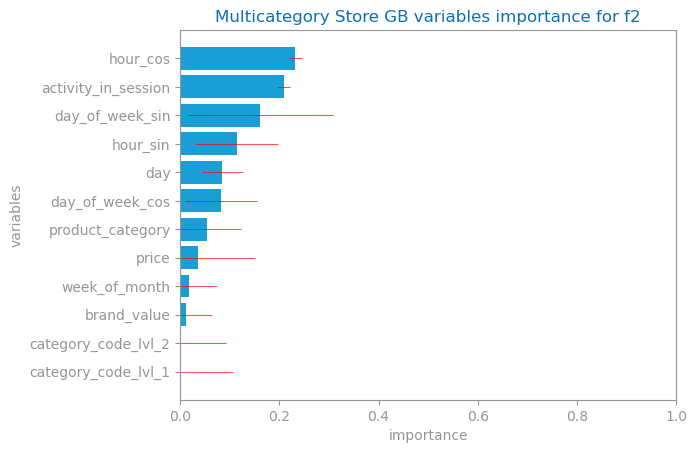

In [24]:
from numpy import std, argsort
from dslabs_functions import plot_horizontal_bar_chart

trees_importances: list[float] = []
for lst_trees in best_model_f2.estimators_:
    for tree in lst_trees:
        trees_importances.append(tree.feature_importances_)

stdevs: list[float] = list(std(trees_importances, axis=0))
importances = best_model_f2.feature_importances_
indices: list[int] = argsort(importances)[::-1]
elems: list[str] = []
imp_values: list[float] = []
for f in range(len(vars)):
    elems += [vars[indices[f]]]
    imp_values.append(importances[indices[f]])
    print(f"{f+1}. {elems[f]} ({importances[indices[f]]})")

figure()
plot_horizontal_bar_chart(
    elems,
    imp_values,
    error=stdevs,
    title=f"{file_tag} GB variables importance for f2",
    xlabel="importance",
    ylabel="variables",
    percentage=True,
)
savefig(f"images/{file_tag}_gb_{f2_params["metric"]}_vars_ranking.png")

In [15]:
##from numpy import std, argsort
##from dslabs_functions import plot_horizontal_bar_chart
##
##trees_importances: list[float] = []
##for lst_trees in best_model_f2.estimators_:
##    for tree in lst_trees:
##        trees_importances.append(tree.feature_importances_)
##
##stdevs: list[float] = list(std(trees_importances, axis=0))
##importances = best_model_f2.feature_importances_
##indices: list[int] = argsort(importances)[::-1]
##elems: list[str] = []
##imp_values: list[float] = []
##for f in range(len(vars)):
##    elems += [vars[indices[f]]]
##    imp_values.append(importances[indices[f]])
##    print(f"{f+1}. {elems[f]} ({importances[indices[f]]})")
##
##figure()
##plot_horizontal_bar_chart(
##    elems,
##    imp_values,
##    error=stdevs,
##    title=f"{file_tag} GB variables importance",
##    xlabel="importance",
##    ylabel="variables",
##    percentage=True,
##)
##savefig(f"images/{file_tag}_gb_{f2_params["metric"]}_vars_ranking.png")

## f2 Overfitting

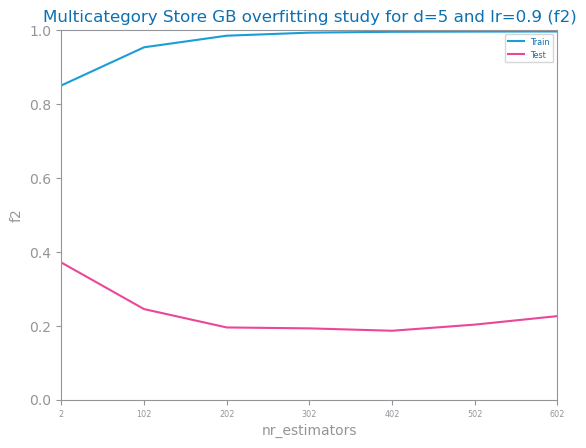

In [25]:
d_max: int = f2_params["params"][0]
lr: float = f2_params["params"][1]
nr_estimators: list[int] = [i for i in range(2, max_trees_eval, max_trees_eval_lag)]

y_tst_values: list[float] = []
y_trn_values: list[float] = []
eval_metric: str = f2_params['metric']

for n in nr_estimators:
    clf = GradientBoostingClassifier(n_estimators=n, max_depth=d_max, learning_rate=lr)
    clf.fit(trnX, trnY)
    prd_tst_Y: array = clf.predict(tstX)
    prd_trn_Y: array = clf.predict(trnX)
    y_tst_values.append(CLASS_EVAL_METRICS[eval_metric](tstY, prd_tst_Y))
    y_trn_values.append(CLASS_EVAL_METRICS[eval_metric](trnY, prd_trn_Y))

figure()
plot_multiline_chart(
    nr_estimators,
    {"Train": y_trn_values, "Test": y_tst_values},
    title=f"{file_tag} GB overfitting study for d={d_max} and lr={lr} ({eval_metric})",
    xlabel="nr_estimators",
    ylabel=str(eval_metric),
    percentage=True,
)
savefig(f"images/{file_tag}_gb_{eval_metric}_overfitting.png")

In [17]:

##d_max: int = f2_params["params"][0]
##lr: float = f2_params["params"][1]
##nr_estimators: list[int] = [i for i in range(2, max_trees_eval, max_trees_eval_lag)]
##
##y_tst_values: list[float] = []
##y_trn_values: list[float] = []
##eval_metric: str = f2_params['metric']
##
##for n in nr_estimators:
##    clf = GradientBoostingClassifier(n_estimators=n, max_depth=d_max, learning_rate=lr)
##    clf.fit(trnX, trnY)
##    prd_tst_Y: array = clf.predict(tstX)
##    prd_trn_Y: array = clf.predict(trnX)
##    y_tst_values.append(CLASS_EVAL_METRICS[eval_metric](tstY, prd_tst_Y))
##    y_trn_values.append(CLASS_EVAL_METRICS[eval_metric](trnY, prd_trn_Y))
##
##figure()
##plot_multiline_chart(
##    nr_estimators,
##    {"Train": y_trn_values, "Test": y_tst_values},
##    title=f"{file_tag} GB overfitting study for d={d_max} and lr={lr}",
##    xlabel="nr_estimators",
##    ylabel=str(eval_metric),
##    percentage=True,
##)
##savefig(f"images/{file_tag}_gb_{eval_metric}_overfitting.png")

# Precision Evaluate for best model

In [18]:
max_trees_eval= 700
max_trees_eval_lag=100

GB best for 100 trees (d=2 and lr=0.5


<Figure size 640x480 with 0 Axes>

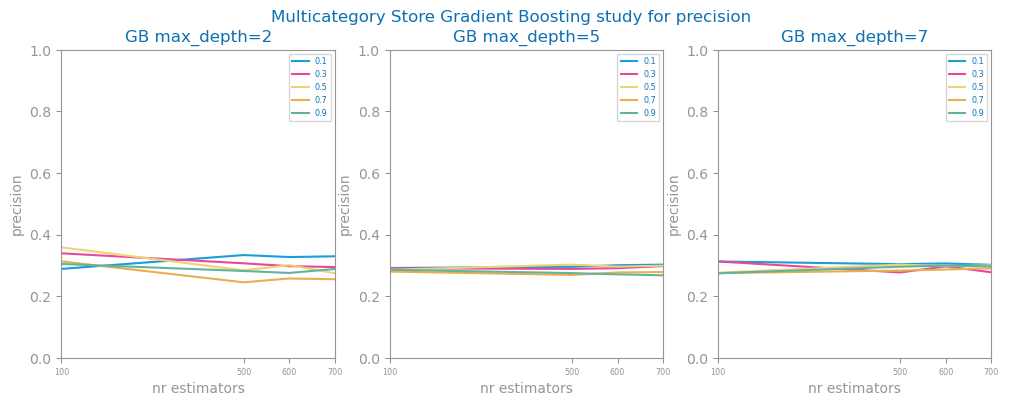

In [19]:
figure()


best_model_prec, prec_params = gradient_boosting_study(
trnX,
trnY,
tstX,
tstY,
nr_max_trees=max_trees_eval,
lag=max_trees_eval_lag,
metric='precision',
file_tag=file_tag

)

savefig(f'images/{file_tag}_GB_{prec_params['metric']}_study.png')
show()

In [37]:
##max_trees_eval=3000
##max_trees_eval_lag=300

## precision study

In [38]:
##figure()
##
##
##best_model_prec, prec_params = gradient_boosting_study(
##trnX,
##trnY,
##tstX,
##tstY,
##nr_max_trees=max_trees_eval,
##lag=max_trees_eval_lag,
##metric='f2',
##file_tag=file_tag
##
##)
##
##savefig(f'images/{file_tag}_GB_{prec_params['metric']}_study.png')
##show()

## precision best model performance

max_trees_eval=700
max_trees_eval_lag=100

<Figure size 640x480 with 0 Axes>

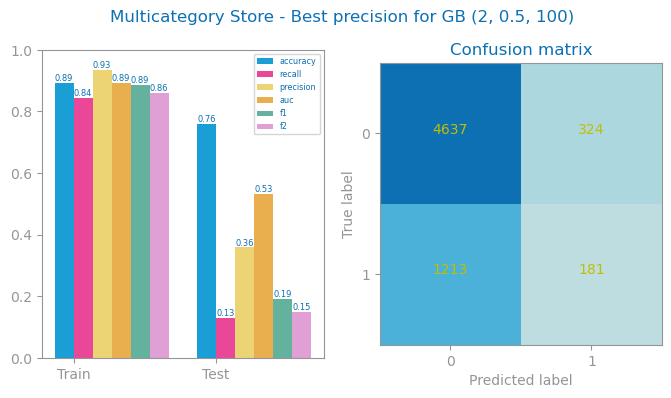

In [21]:
prd_trn: array = best_model_prec.predict(trnX)
prd_tst: array = best_model_prec.predict(tstX)
figure()
plot_evaluation_results(prec_params, trnY, prd_trn, tstY, prd_tst, labels,file_tag=file_tag)
savefig(f'images/{file_tag}_GB_{prec_params["name"]}_best_{prec_params["metric"]}_eval.png')
show()

max_trees_eval=3000
max_trees_eval_lag=300

In [40]:
#prd_trn: array = best_model_prec.predict(trnX)
#prd_tst: array = best_model_prec.predict(tstX)
#figure()
#plot_evaluation_results(prec_params, trnY, prd_trn, tstY, prd_tst, labels,file_tag=file_tag)
#savefig(f'images/{file_tag}_GB_{prec_params["name"]}_best_{prec_params["metric"]}_eval.png')
#show()

## precision Variables importance


max_trees_eval=700
max_trees_eval_lag=100

1. hour_cos (0.24183799937076503)
2. activity_in_session (0.21122396354605727)
3. hour_sin (0.17236492145322288)
4. day_of_week_sin (0.17143262441370663)
5. day (0.09024499280172185)
6. day_of_week_cos (0.052572600015846245)
7. product_category (0.031031090827044513)
8. week_of_month (0.014666178078388796)
9. brand_value (0.008214170901367026)
10. price (0.006113055917872728)
11. category_code_lvl_2 (0.00029840267400690006)
12. category_code_lvl_1 (0.0)


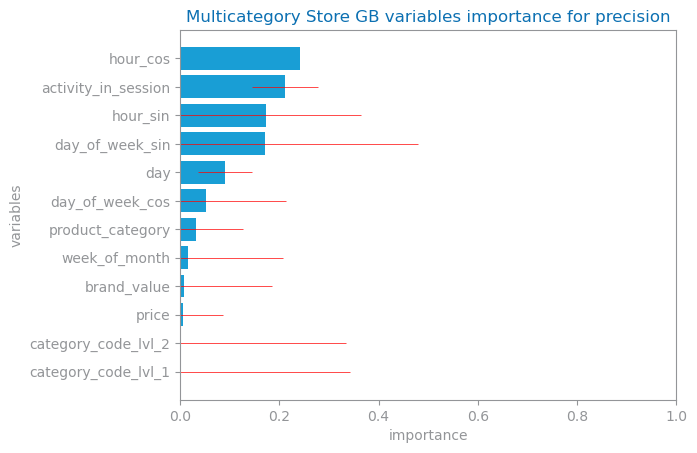

In [22]:
from numpy import std, argsort
from dslabs_functions import plot_horizontal_bar_chart

trees_importances: list[float] = []
for lst_trees in best_model_prec.estimators_:
    for tree in lst_trees:
        trees_importances.append(tree.feature_importances_)

stdevs: list[float] = list(std(trees_importances, axis=0))
importances = best_model_prec.feature_importances_
indices: list[int] = argsort(importances)[::-1]
elems: list[str] = []
imp_values: list[float] = []
for f in range(len(vars)):
    elems += [vars[indices[f]]]
    imp_values.append(importances[indices[f]])
    print(f"{f+1}. {elems[f]} ({importances[indices[f]]})")

figure()
plot_horizontal_bar_chart(
    elems,
    imp_values,
    error=stdevs,
    title=f"{file_tag} GB variables importance for precision",
    xlabel="importance",
    ylabel="variables",
    percentage=True,
)
savefig(f"images/{file_tag}_gb_{prec_params["metric"]}_vars_ranking.png")

max_trees_eval=3000
max_trees_eval_lag=300

In [42]:
#from numpy import std, argsort
#from dslabs_functions import plot_horizontal_bar_chart
#
#trees_importances: list[float] = []
#for lst_trees in best_model_prec.estimators_:
#    for tree in lst_trees:
#        trees_importances.append(tree.feature_importances_)
#
#stdevs: list[float] = list(std(trees_importances, axis=0))
#importances = best_model_prec.feature_importances_
#indices: list[int] = argsort(importances)[::-1]
#elems: list[str] = []
#imp_values: list[float] = []
#for f in range(len(vars)):
#    elems += [vars[indices[f]]]
#    imp_values.append(importances[indices[f]])
#    print(f"{f+1}. {elems[f]} ({importances[indices[f]]})")
#
#figure()
#plot_horizontal_bar_chart(
#    elems,
#    imp_values,
#    error=stdevs,
#    title=f"{file_tag} GB variables importance",
#    xlabel="importance",
#    ylabel="variables",
#    percentage=True,
#)
#savefig(f"images/{file_tag}_gb_{prec_params["metric"]}_vars_ranking.png")

## precision overfitting

max_trees_eval=700
max_trees_eval_lag=100

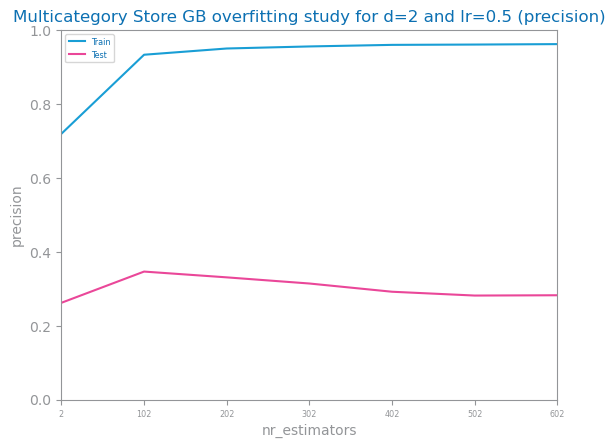

In [23]:

d_max: int = prec_params["params"][0]
lr: float = prec_params["params"][1]
nr_estimators: list[int] = [i for i in range(2, max_trees_eval, max_trees_eval_lag)]

y_tst_values: list[float] = []
y_trn_values: list[float] = []
eval_metric: str = prec_params['metric']

for n in nr_estimators:
    clf = GradientBoostingClassifier(n_estimators=n, max_depth=d_max, learning_rate=lr)
    clf.fit(trnX, trnY)
    prd_tst_Y: array = clf.predict(tstX)
    prd_trn_Y: array = clf.predict(trnX)
    y_tst_values.append(CLASS_EVAL_METRICS[eval_metric](tstY, prd_tst_Y))
    y_trn_values.append(CLASS_EVAL_METRICS[eval_metric](trnY, prd_trn_Y))

figure()
plot_multiline_chart(
    nr_estimators,
    {"Train": y_trn_values, "Test": y_tst_values},
    title=f"{file_tag} GB overfitting study for d={d_max} and lr={lr} ({eval_metric})",
    xlabel="nr_estimators",
    ylabel=str(eval_metric),
    percentage=True,
)
savefig(f"images/{file_tag}_gb_{eval_metric}_overfitting.png")

max_trees_eval=3000
max_trees_eval_lag=300

In [44]:

#d_max: int = prec_params["params"][0]
#lr: float = prec_params["params"][1]
#nr_estimators: list[int] = [i for i in range(2, max_trees_eval, max_trees_eval_lag)]
#
#y_tst_values: list[float] = []
#y_trn_values: list[float] = []
#eval_metric: str = prec_params['metric']
#
#for n in nr_estimators:
#    clf = GradientBoostingClassifier(n_estimators=n, max_depth=d_max, learning_rate=lr)
#    clf.fit(trnX, trnY)
#    prd_tst_Y: array = clf.predict(tstX)
#    prd_trn_Y: array = clf.predict(trnX)
#    y_tst_values.append(CLASS_EVAL_METRICS[eval_metric](tstY, prd_tst_Y))
#    y_trn_values.append(CLASS_EVAL_METRICS[eval_metric](trnY, prd_trn_Y))
#
#figure()
#plot_multiline_chart(
#    nr_estimators,
#    {"Train": y_trn_values, "Test": y_tst_values},
#    title=f"{file_tag} GB overfitting study for d={d_max} and lr={lr}",
#    xlabel="nr_estimators",
#    ylabel=str(eval_metric),
#    percentage=True,
#)
#savefig(f"images/{file_tag}_gb_{eval_metric}_overfitting.png")

# Analysis


We aim to achieve the minimum number of false positives while maintaining a high number of true positives. This enable us to effectively target customers who are likely to purchase (Tru positives). And This approach also helps reduce the budget spent on users we believed would buy but ultimately do not (False Positives).

Dataset used:
- Sample from balancing dataset was used, as running the evaluation on the with complete balancing dataset was too time-consuming.


Precision/recall/ f2 study:
- F2  best with (100=trees=, d=5 and f=0.9)
- Precision best (100 trees, d=2 and lr=0.5) 

Various estimators were tested up to 750. The best model for F2 had a depth of 5 levels, trained with 100 trees (100 trees, d=5, f=0.9). This model achieved a precision of 29% and an accuracy of 71%. However, it also has a low recall of 23%, resulting in a high number of false positives, a very high number of true negatives, and very few true positives. For precision, the best model has a smaller depth with the same number of trees (100 trees, d=2, lr=0.5). This model achieved a high accuracy of 76% and the highest precision value of 36% among all algorithms. However, the recall is still low at 13%, indicating we are correctly predicting all true negatives but not correctly predicting true positives. Both models are not ideal for classifying our dataset due to their low recalls and few true positives. However, we will choose the best fit model for precision because it has a higher number of true positives and a better combination for F2. For both models, hour_cos, activity_in_session, and day_of_week-sin are the most relevant variables. Comparing with previous algorithms like Decision Trees and Random Forests, the relevant variables are similar, but hour_cos has more relevance in Gradient Boosting.

Regarding overfitting, both models are overfitting. In the case of F2, overfitting is evident with a minimal number of estimators. A higher depth increases complexity, what makes trees to adapt to the training data rather than beign susffiente generic to adapt to unseen test data. Overfitting in precision is more gradual and becomes visible at estimators greater than 102. While training continues to increase slightly, precision on the test set begins to decrease after 102.


For f2, these are the most relevant values:
1. hour_cos (0.2322568793955808)
2. activity_in_session (0.20811224280119267)
3. day_of_week_sin (0.16117585538757728)
4. hour_sin (0.11352829315141737)
5. day (0.08502286580910588)
6. day_of_week_cos (0.0813694055560481)
7. product_category (0.05339759538668198)
8. price (0.03553203017750099)
9. week_of_month (0.016946332364315714)
10. brand_value (0.011851772224664138)
11. category_code_lvl_2 (0.0005940387357398357)
12. category_code_lvl_1 (0.00021268901017520124)


For precision:
1. hour_cos (0.24183799937076503)
2. activity_in_session (0.21122396354605727)
3. hour_sin (0.17236492145322288)
4. day_of_week_sin (0.17143262441370663)
5. day (0.09024499280172185)
6. day_of_week_cos (0.052572600015846245)
7. product_category (0.031031090827044513)
8. week_of_month (0.014666178078388796)
9. brand_value (0.008214170901367026)
10. price (0.006113055917872728)
11. category_code_lvl_2 (0.00029840267400690006)
12. category_code_lvl_1 (0.0)

## Extended analysis

- Various estimators were tested up to 750. The best model for F2 had a depth of 5 levels, trained with 100 trees (100 trees, d=5, f=0.9). This model achieved a precision of 29% and an accuracy of 71%. However, it also has a low recall of 23%, resulting in a high number of false positives, a very high number of true negatives, and very few true positives. For precision, the best model has a smaller depth with the same number of trees (100 trees, d=2, lr=0.5). This model achieved a high accuracy of 76% and the highest precision value of 36% among all algorithms. However, the recall is still low at 13%, indicating we are correctly predicting all true negatives but not correctly predicting true positives. Both models are not ideal for classifying our dataset due to their low recalls and few true positives. However, we will choose the best fit model for precision because it has a higher number of true positives and a better combination for F2. For both models, hour_cos, activity_in_session, and day_of_week-sin are the most relevant variables. 

- Comparing with previous algorithms like Decision Trees and Random Forests, the relevant variables are similar, but hour_cos has more relevance in Gradient Boosting.

- Regarding overfitting, both models are overfitting. In the case of F2, overfitting is evident with a minimal number of estimators. A higher depth increases complexity, what makes trees to adapt to the training data rather than beign susffiente generic to adapt to unseen test data. Overfitting in precision is more gradual and becomes visible at estimators greater than 102. While training continues to increase slightly, precision on the test set begins to decrease after 102.

## Short analysis for the report:
- 750 estimators were tested. The best model for F2 (100 trees, d=5) had 29% precision and 71% accuracy, but low recall. The precision model (d=2) had 76% accuracy and 36% precision. Both models overfit.